1. Import liabraries


In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from scipy import stats

In [25]:
# Set random seed for reproducibility
np.random.seed(42)

# Load data
df = pd.read_csv('tip_dataset.csv')

# Basic data exploration
print("Dataset Shape:", df.shape)
print("\nDataset Information:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nDescriptive Statistics:")
print(df.describe())


Dataset Shape: (244, 7)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   tip         244 non-null    float64
 2   sex         244 non-null    object 
 3   smoker      244 non-null    object 
 4   day         244 non-null    object 
 5   time        244 non-null    object 
 6   size        244 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 13.5+ KB
None

Missing Values:
total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64

Descriptive Statistics:
       total_bill         tip        size
count  244.000000  244.000000  244.000000
mean    19.785943    2.998279    2.569672
std      8.902412    1.383638    0.951100
min      3.070000    1.000000    1.000000
25%     13.347500    2.000000    2.0

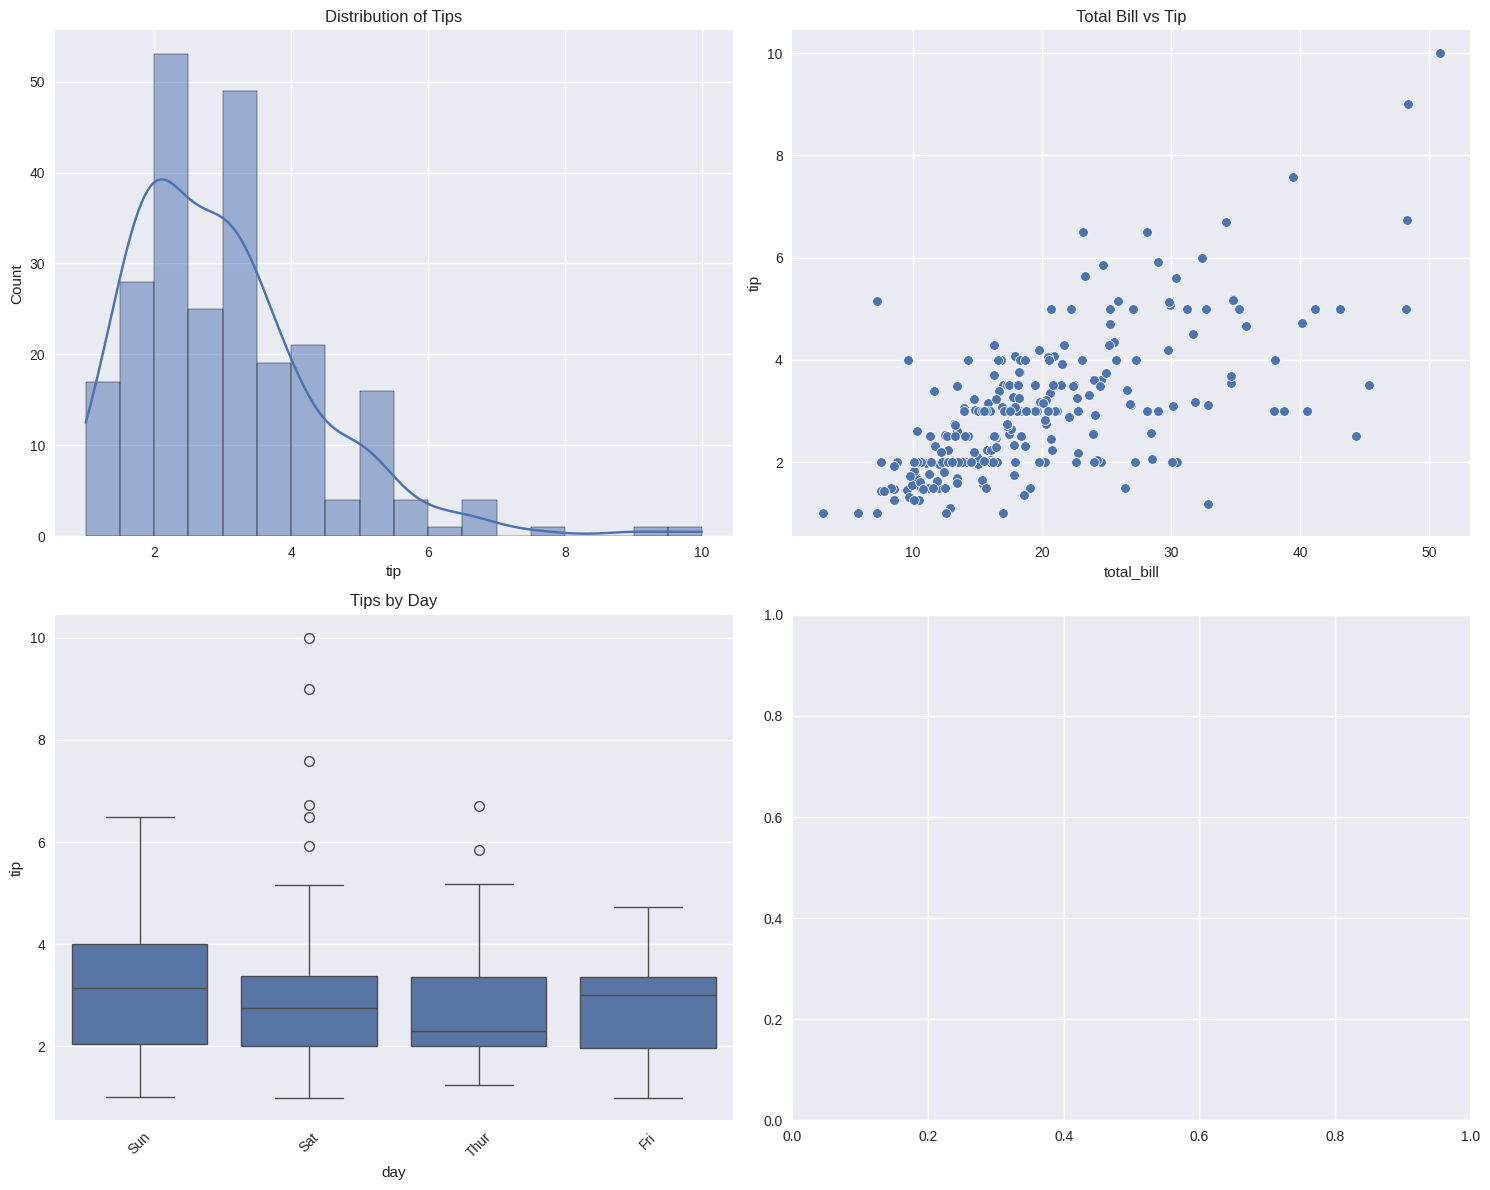

<Figure size 800x550 with 0 Axes>

In [29]:
# Part 2: Exploratory Data Analysis
plt.style.use("seaborn-v0_8")

# Create visualization for numerical variables
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Distribution of tips
sns.histplot(data=df, x='tip', kde=True, ax=axes[0,0])
axes[0,0].set_title('Distribution of Tips')

# Scatter plot: Total Bill vs Tip
sns.scatterplot(data=df, x='total_bill', y='tip', ax=axes[0,1])
axes[0,1].set_title('Total Bill vs Tip')

# Box plot: Tips by Day
sns.boxplot(data=df, x='day', y='tip', ax=axes[1,0])
axes[1,0].set_title('Tips by Day')
axes[1,0].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# Box plot: Tips by Time
sns.boxplot(data=df, x='time', y='tip', ax=axes[1,1])
axes[1,1].set_title('Tips by Time')

plt.tight_layout()
plt.show()



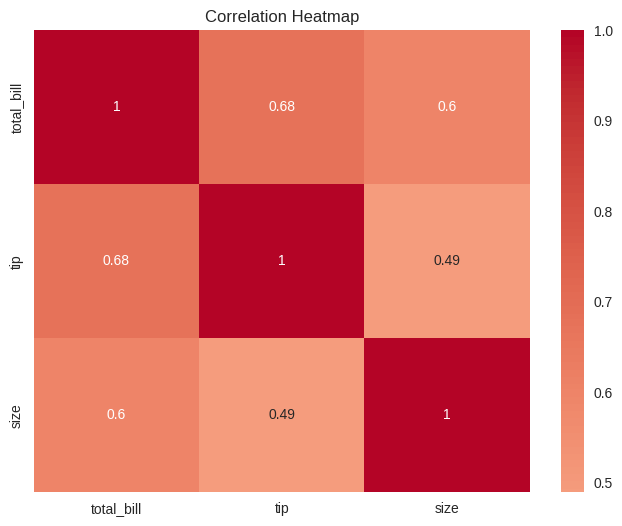

In [30]:
# Correlation Analysis
numeric_cols = ['total_bill', 'tip', 'size']
correlation = df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

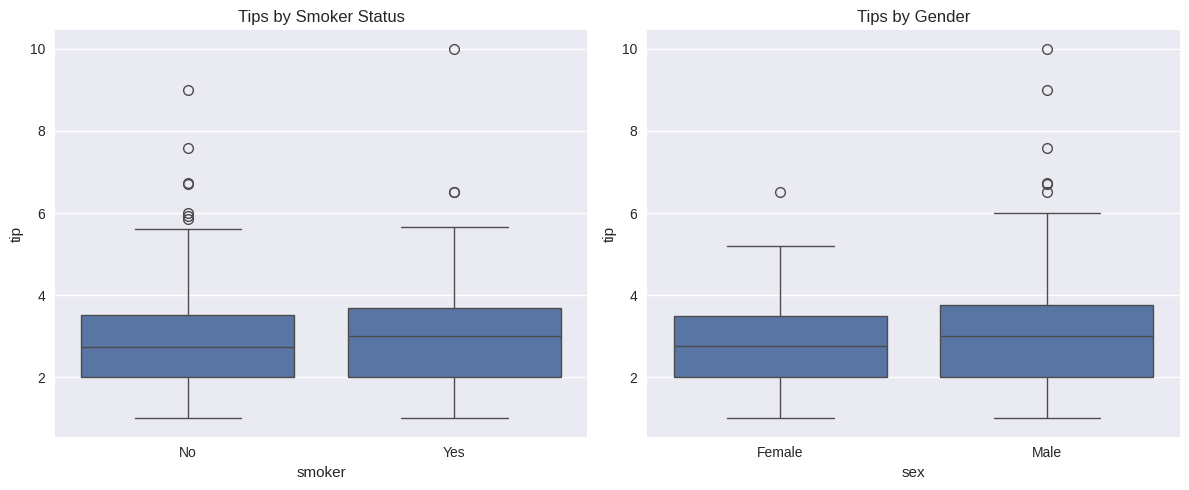

In [31]:
# Additional categorical analysis
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Tips by smoker status
sns.boxplot(data=df, x='smoker', y='tip', ax=axes[0])
axes[0].set_title('Tips by Smoker Status')

# Tips by gender
sns.boxplot(data=df, x='sex', y='tip', ax=axes[1])
axes[1].set_title('Tips by Gender')

plt.tight_layout()
plt.show()

In [32]:
# Print summary statistics by categories
print("\nAverage Tips by Categories:")
categories = ['day', 'time', 'sex', 'smoker']
for cat in categories:
    print(f"\nMean tips by {cat}:")
    print(df.groupby(cat)['tip'].mean().round(2))


Average Tips by Categories:

Mean tips by day:
day
Fri     2.73
Sat     2.99
Sun     3.26
Thur    2.77
Name: tip, dtype: float64

Mean tips by time:
time
Dinner    3.10
Lunch     2.73
Name: tip, dtype: float64

Mean tips by sex:
sex
Female    2.83
Male      3.09
Name: tip, dtype: float64

Mean tips by smoker:
smoker
No     2.99
Yes    3.01
Name: tip, dtype: float64


In [34]:
# Part 3: Data Preprocessing and Model Building

# Prepare features
X = df.drop('tip', axis=1)
y = df['tip']

# Split features into numeric and categorical
numeric_features = ['total_bill', 'size']
categorical_features = ['sex', 'smoker', 'day', 'time']

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models with hyperparameters
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'Decision Tree': DecisionTreeRegressor(max_depth=5, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    'SVR': SVR(kernel='rbf', C=1.0),
    'KNN': KNeighborsRegressor(n_neighbors=5)
}

In [35]:
# Train and evaluate models
results = {}
predictions = {}

for name, model in models.items():
    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # Train model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)
    predictions[name] = y_pred

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Calculate cross-validation score
    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')

    results[name] = {
        'MSE': round(mse, 4),
        'RMSE': round(rmse, 4),
        'R2': round(r2, 4),
        'CV_R2_mean': round(cv_scores.mean(), 4),
        'CV_R2_std': round(cv_scores.std(), 4)
    }



Model Performance Comparison:
                      MSE    RMSE      R2  CV_R2_mean  CV_R2_std
Linear Regression  0.7034  0.8387  0.4373      0.4215     0.1353
Ridge              0.7007  0.8370  0.4395      0.4231     0.1334
Lasso              0.6122  0.7824  0.5102      0.4573     0.1083
Decision Tree      0.8490  0.9214  0.3208      0.3384     0.1046
Random Forest      0.9078  0.9528  0.2737      0.3981     0.1158
SVR                0.7095  0.8423  0.4324      0.4049     0.1302
KNN                0.8145  0.9025  0.3484      0.3378     0.0832


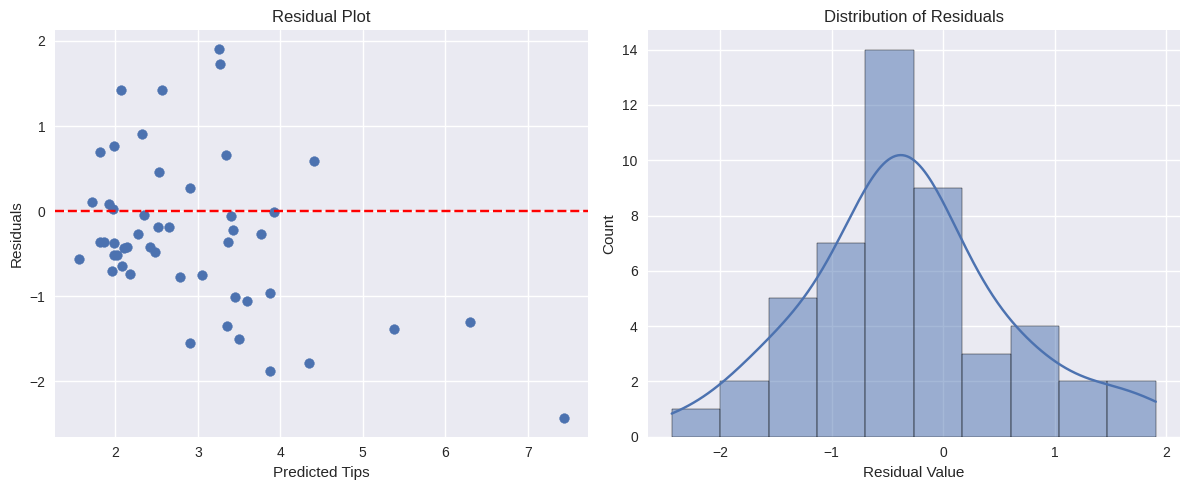

In [38]:
# Convert results to DataFrame and display
results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:")
print(results_df)

# Part 4: Best Model Analysis (Random Forest)
best_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42))
])

best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)

# Residual Analysis
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_pred_best, y_test - y_pred_best)
plt.xlabel('Predicted Tips')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')

plt.subplot(1, 2, 2)
sns.histplot(y_test - y_pred_best, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residual Value')
plt.tight_layout()
plt.show()



In [37]:
# Feature Importance Analysis
feature_names = (numeric_features +
                [f"{feat}_{val}" for feat, vals in
                 zip(categorical_features,
                     best_model.named_steps['preprocessor']
                     .named_transformers_['cat'].categories_)
                 for val in vals[1:]])

importance = best_model.named_steps['regressor'].feature_importances_

In [39]:
# Create and sort feature importance DataFrame
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

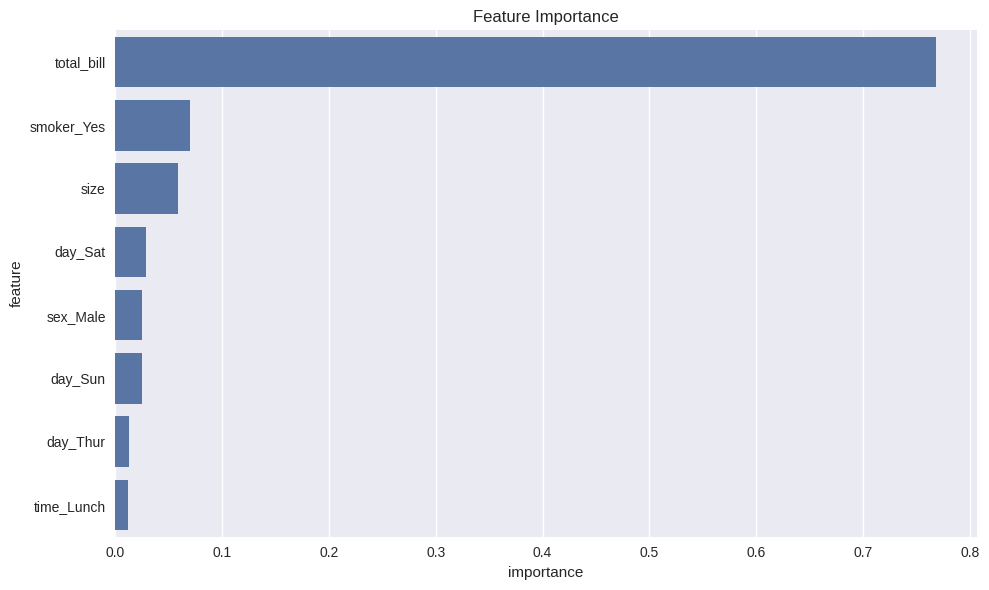


Top 5 Most Important Features:
      feature  importance
0  total_bill    0.768309
3  smoker_Yes    0.070167
1        size    0.058426
4     day_Sat    0.028486
2    sex_Male    0.025199

Best Model (Random Forest) Performance Metrics:
R² Score: 0.2737
RMSE: 0.9528

Average Tips Summary:

By Day:
day
Sun     3.26
Sat     2.99
Thur    2.77
Fri     2.73
Name: tip, dtype: float64

By Time:
time
Dinner    3.10
Lunch     2.73
Name: tip, dtype: float64

By Smoker Status:
smoker
No     2.99
Yes    3.01
Name: tip, dtype: float64


In [40]:
# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# Print final insights
print("\nTop 5 Most Important Features:")
print(feature_importance.head())

# Calculate and print performance metrics for best model
print("\nBest Model (Random Forest) Performance Metrics:")
print(f"R² Score: {r2_score(y_test, y_pred_best):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_best)):.4f}")

# Print average tips by key categories
print("\nAverage Tips Summary:")
print("\nBy Day:")
print(df.groupby('day')['tip'].mean().sort_values(ascending=False).round(2))
print("\nBy Time:")
print(df.groupby('time')['tip'].mean().round(2))
print("\nBy Smoker Status:")
print(df.groupby('smoker')['tip'].mean().round(2))